In [2]:
import os

In [18]:
import matplotlib.pyplot as plt

In [3]:
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory
    
    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [4]:
import requests
import zipfile
from pathlib import Path

In [27]:
data_path = Path("data/X_ray_image_and_mask_for_U_net_training")
image_path = data_path / "CXR_png"
masks_path = data_path / "masks"

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\X_ray_image_and_mask_for_U_net_training\CXR_png
There are 0 directories and 200 images in data\X_ray_image_and_mask_for_U_net_training\CXR_png\test
There are 0 directories and 600 images in data\X_ray_image_and_mask_for_U_net_training\CXR_png\train


In [7]:
#setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/X_ray_image_and_mask_for_U_net_training/CXR_png/train'),
 WindowsPath('data/X_ray_image_and_mask_for_U_net_training/CXR_png/test'))

In [10]:
import random
from PIL import Image

In [60]:
#set seed
random.seed(42)

#Get all image paths (* means 'any combination')
image_path_list = list(image_path.glob("*/*.png"))

#Get random image path
random_image_path = random.choice(image_path_list)

#Get image class from path name (name of directory)
image_class = random_image_path.parent.stem

#Open image
img = Image.open(random_image_path)

#Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

IndexError: Cannot choose from an empty sequence

In [16]:
#Transforming data into tensors, then into torch.utils.data.Dataset
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [124]:
data_transform = transforms.Compose([transforms.ToPILImage(),
    #Resize the images to 572x572
    transforms.Resize(size = (128,128)),
    #turn the imahe into torch.Tensor
    transforms.ToTensor() #this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ])

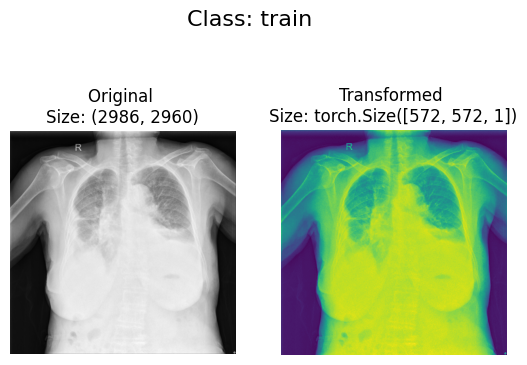

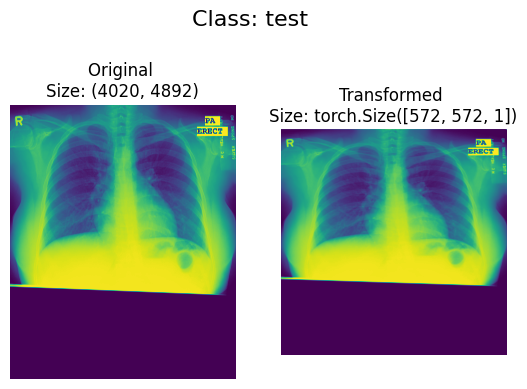

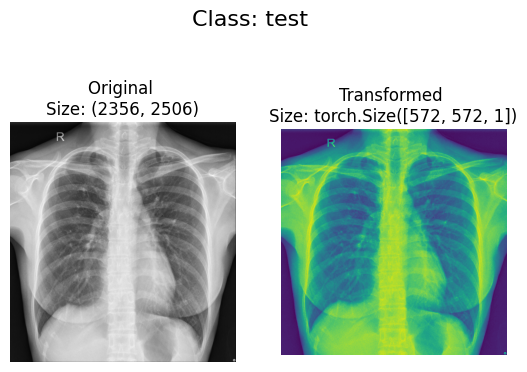

In [22]:
def plot_transformed_images(image_paths, transform,n=3,seed=42):
    """Plots a series of random images from image_paths.
    
    Will open n image from image_paths, transform them with transform and
    plot them side by side
    
    Args:
        image_path (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int,optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis('off')
            
            #transform and plot the image
            #note: permute changes shape of image to suit matplotlib
            #Pytorch default is [C,H,W] but Matplotlib is [H,W,C]
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis('off')
            
            fig.suptitle(f'Class: {image_path.parent.stem}' , fontsize = 16)
            
plot_transformed_images(image_path_list,transform = data_transform, n=3)

In [24]:
#Using ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                 transform = data_transform,
                                 target_transform = None)
test_data = datasets.ImageFolder(root = test_dir,
                                transform = data_transform)
print(f'Train data:\n{train_data}\nTest data:\n{test_data}')


Train data:
Dataset ImageFolder
    Number of datapoints: 600
    Root location: data\X_ray_image_and_mask_for_U_net_training\CXR_png\train
    StandardTransform
Transform: Compose(
               Resize(size=(572, 572), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 200
    Root location: data\X_ray_image_and_mask_for_U_net_training\CXR_png\test
    StandardTransform
Transform: Compose(
               Resize(size=(572, 572), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [25]:
train_data.classes

['xray']

In [26]:
train_data.class_to_idx

{'xray': 0}

In [115]:
#defining U-Net parameters
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

#initialize learning rate, number of epochs to train for and batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

#define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

#threshold to filter weak predictions
THRESHOLD = 0.5

#define path to the base output directory
BASE_OUTPUT = "output"

MODEL_PATH = os.path.join(BASE_OUTPUT,"unet_xray.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT,"plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT,"test_paths.txt"])

In [116]:
from torch.utils.data import Dataset
class SegmentationDataset(Dataset):
    def __init__(self,imagePaths,maskPaths,transforms):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.imagePaths)
    def __getitem__(self,idx):
        imagePath = self.imagePaths[idx]
        
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx],0)
        
        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return (image,mask)

In [33]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F

In [58]:
import cv2

In [117]:
class Block(Module):
    def __init__(self,inChannels,outChannels):
        super().__init__()
        self.conv1 = Conv2d(inChannels,outChannels,3)
        self.relu = ReLU()
        self.conv2 = Conv2d(outChannels,outChannels,3)
    
    def forward(self,x):
        return self.conv2(self.relu(self.conv1(x)))

In [118]:
class Encoder(Module):
    def __init__(self,channels = (3,16,32,64)):
        super().__init__()
        self.encBlocks = ModuleList([Block(
        channels[i],channels[i+1]) for i in range(len(channels)-1)])
        self.pool = MaxPool2d(2)
    
    def forward(self,x):
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        return blockOutputs

In [119]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList([ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)])
        
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
    
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [90]:
class UNet(Module):
    def __init__(self,encChannels = (3,16,32,64),
    decChannels = (64,32,16),
    nbClasses =1,retainDim = True,
    outSize = (INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        self.head = Conv2d(decChannels[-1],nbClasses,1)
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self,x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0],
                                  encFeatures[::-1][1:])
        map = self.head(decFeatures)
        
        if self.retainDim:
            map = F.interpolate(map,self.outSize)
            
        return map

In [84]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os
from torch import nn

In [120]:
imagePaths = sorted(list(paths.list_images(image_path)))
maskPaths = sorted(list(paths.list_images(masks_path)))

split = train_test_split(imagePaths,maskPaths,test_size = 0.25,random_state =42)

(trainImages,testImages) = split[:2]
(trainMasks,testMasks) = split[2:]

print("[INFO] saving testing image paths")
f = open(test_dir,"w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths


In [125]:
trainDS = SegmentationDataset(imagePaths = trainImages, 
                              maskPaths = trainMasks, 
                              transforms = data_transform)
testDS = SegmentationDataset(imagePaths = testImages,
                              maskPaths = testMasks,
                              transforms = data_transform)

trainLoader = DataLoader(trainDS, shuffle = True, 
                        batch_size = BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle = False, batch_size = BATCH_SIZE)


In [126]:
len(trainDS[0][0])

3

In [127]:
trainDS[0][0].size()

torch.Size([3, 128, 128])

trainDS

In [130]:
unet = UNet()
lossfn = BCEWithLogitsLoss()
optimizer  = Adam(unet.parameters(),lr = INIT_LR)

trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

H = {"train_loss" :[], "test_loss" :[]}

In [132]:
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    unet.train()
    totalTrainLoss = 0
    totalTestLoss = 0
    
    for (i,(x,y)) in enumerate(trainLoader):
        pred = unet(x)
        loss = lossfn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        totalTrainLoss += loss
        
    with torch.inference_mode():
        unet.eval()
        
        for(x,y) in testLoader:
            pred = unet(x)
            
            totalTestLoss += lossfn(pred,y)
        
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    H["train_loss"].append(avgTrainLoss.detach().numpy())
    H["test_loss"].append(avgTestLoss.detach().numpy())
    
    print("EPOCH: {}/{}".format(e+1,NUM_EPOCHS))
    print("Train loss: {:,.6f},Test loss: {:.4f}".format(avgTrainLoss,avgTestLoss))
    
endTime = time.time()
print("[INFO] total time taken to train the model : {:.2f}s").format(endTime - startTime)

  2%|██                                                                              | 1/40 [05:30<3:34:56, 330.69s/it]

EPOCH: 1/40
Train loss: 0.671428,Test loss: 0.7142


  5%|████                                                                            | 2/40 [10:51<3:25:51, 325.04s/it]

EPOCH: 2/40
Train loss: 0.601234,Test loss: 0.7036


  8%|██████                                                                          | 3/40 [16:12<3:19:12, 323.05s/it]

EPOCH: 3/40
Train loss: 0.593643,Test loss: 0.6966


 10%|████████                                                                        | 4/40 [21:29<3:12:29, 320.82s/it]

EPOCH: 4/40
Train loss: 0.583479,Test loss: 0.6827


 12%|██████████                                                                      | 5/40 [26:50<3:07:12, 320.93s/it]

EPOCH: 5/40
Train loss: 0.573948,Test loss: 0.6658


 15%|████████████                                                                    | 6/40 [32:08<3:01:16, 319.89s/it]

EPOCH: 6/40
Train loss: 0.558571,Test loss: 0.6439


 18%|██████████████                                                                  | 7/40 [37:24<2:55:10, 318.50s/it]

EPOCH: 7/40
Train loss: 0.545687,Test loss: 0.6351


 20%|████████████████                                                                | 8/40 [42:40<2:49:30, 317.84s/it]

EPOCH: 8/40
Train loss: 0.541780,Test loss: 0.6306


 22%|██████████████████                                                              | 9/40 [47:58<2:44:13, 317.84s/it]

EPOCH: 9/40
Train loss: 0.537232,Test loss: 0.6201


 25%|███████████████████▊                                                           | 10/40 [53:16<2:38:55, 317.86s/it]

EPOCH: 10/40
Train loss: 0.521046,Test loss: 0.5967


 28%|█████████████████████▋                                                         | 11/40 [58:33<2:33:32, 317.69s/it]

EPOCH: 11/40
Train loss: 0.507345,Test loss: 0.5665


 30%|███████████████████████                                                      | 12/40 [1:03:52<2:28:18, 317.80s/it]

EPOCH: 12/40
Train loss: 0.477369,Test loss: 0.5348


 32%|█████████████████████████                                                    | 13/40 [1:09:09<2:23:00, 317.81s/it]

EPOCH: 13/40
Train loss: 0.453204,Test loss: 0.4997


 35%|██████████████████████████▉                                                  | 14/40 [1:14:26<2:17:35, 317.54s/it]

EPOCH: 14/40
Train loss: 0.437583,Test loss: 0.5305


 38%|████████████████████████████▉                                                | 15/40 [1:19:43<2:12:13, 317.35s/it]

EPOCH: 15/40
Train loss: 0.451613,Test loss: 0.5149


 40%|██████████████████████████████▊                                              | 16/40 [1:25:02<2:07:09, 317.88s/it]

EPOCH: 16/40
Train loss: 0.423355,Test loss: 0.4740


 42%|████████████████████████████████▋                                            | 17/40 [1:30:22<2:02:01, 318.33s/it]

EPOCH: 17/40
Train loss: 0.403994,Test loss: 0.4695


 45%|██████████████████████████████████▋                                          | 18/40 [1:35:38<1:56:31, 317.81s/it]

EPOCH: 18/40
Train loss: 0.399354,Test loss: 0.4504


 48%|████████████████████████████████████▌                                        | 19/40 [1:40:55<1:51:05, 317.40s/it]

EPOCH: 19/40
Train loss: 0.391811,Test loss: 0.4307


 50%|██████████████████████████████████████▌                                      | 20/40 [1:46:11<1:45:44, 317.20s/it]

EPOCH: 20/40
Train loss: 0.380109,Test loss: 0.4199


 52%|████████████████████████████████████████▍                                    | 21/40 [1:51:28<1:40:21, 316.92s/it]

EPOCH: 21/40
Train loss: 0.375834,Test loss: 0.4169


 55%|██████████████████████████████████████████▎                                  | 22/40 [1:56:44<1:34:59, 316.65s/it]

EPOCH: 22/40
Train loss: 0.370778,Test loss: 0.4156


 57%|████████████████████████████████████████████▎                                | 23/40 [2:01:59<1:29:38, 316.39s/it]

EPOCH: 23/40
Train loss: 0.369232,Test loss: 0.4171


 60%|██████████████████████████████████████████████▏                              | 24/40 [2:07:15<1:24:16, 316.06s/it]

EPOCH: 24/40
Train loss: 0.364043,Test loss: 0.3961


 62%|████████████████████████████████████████████████▏                            | 25/40 [2:12:29<1:18:53, 315.59s/it]

EPOCH: 25/40
Train loss: 0.356018,Test loss: 0.3929


 65%|██████████████████████████████████████████████████                           | 26/40 [2:17:43<1:13:30, 315.04s/it]

EPOCH: 26/40
Train loss: 0.352217,Test loss: 0.3843


 68%|███████████████████████████████████████████████████▉                         | 27/40 [2:22:59<1:08:19, 315.36s/it]

EPOCH: 27/40
Train loss: 0.348109,Test loss: 0.3929


 70%|█████████████████████████████████████████████████████▉                       | 28/40 [2:28:16<1:03:11, 315.95s/it]

EPOCH: 28/40
Train loss: 0.353119,Test loss: 0.3881


 72%|█████████████████████████████████████████████████████████▎                     | 29/40 [2:33:34<57:59, 316.28s/it]

EPOCH: 29/40
Train loss: 0.351022,Test loss: 0.3829


 75%|███████████████████████████████████████████████████████████▎                   | 30/40 [2:38:52<52:50, 317.08s/it]

EPOCH: 30/40
Train loss: 0.345168,Test loss: 0.3864


 78%|█████████████████████████████████████████████████████████████▏                 | 31/40 [2:44:09<47:31, 316.84s/it]

EPOCH: 31/40
Train loss: 0.343797,Test loss: 0.3794


 80%|███████████████████████████████████████████████████████████████▏               | 32/40 [2:49:26<42:16, 317.00s/it]

EPOCH: 32/40
Train loss: 0.343222,Test loss: 0.3775


 82%|█████████████████████████████████████████████████████████████████▏             | 33/40 [2:54:44<37:00, 317.23s/it]

EPOCH: 33/40
Train loss: 0.338577,Test loss: 0.3712


 85%|███████████████████████████████████████████████████████████████████▏           | 34/40 [3:00:02<31:45, 317.60s/it]

EPOCH: 34/40
Train loss: 0.339075,Test loss: 0.3691


 88%|█████████████████████████████████████████████████████████████████████▏         | 35/40 [3:05:22<26:31, 318.30s/it]

EPOCH: 35/40
Train loss: 0.334711,Test loss: 0.3680


 90%|███████████████████████████████████████████████████████████████████████        | 36/40 [3:10:44<21:16, 319.21s/it]

EPOCH: 36/40
Train loss: 0.332943,Test loss: 0.3726


 92%|█████████████████████████████████████████████████████████████████████████      | 37/40 [3:15:56<15:51, 317.20s/it]

EPOCH: 37/40
Train loss: 0.329948,Test loss: 0.3661


 95%|███████████████████████████████████████████████████████████████████████████    | 38/40 [3:21:12<10:33, 316.68s/it]

EPOCH: 38/40
Train loss: 0.332785,Test loss: 0.3686


 98%|█████████████████████████████████████████████████████████████████████████████  | 39/40 [3:26:29<05:16, 316.75s/it]

EPOCH: 39/40
Train loss: 0.336052,Test loss: 0.3757


100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [3:31:44<00:00, 317.62s/it]

EPOCH: 40/40
Train loss: 0.336181,Test loss: 0.3589
[INFO] total time taken to train the model : {:.2f}s


AttributeError: 'NoneType' object has no attribute 'format'

In [135]:
(endTime - startTime)/60 #minutes taken to train the model

211.74997220039367

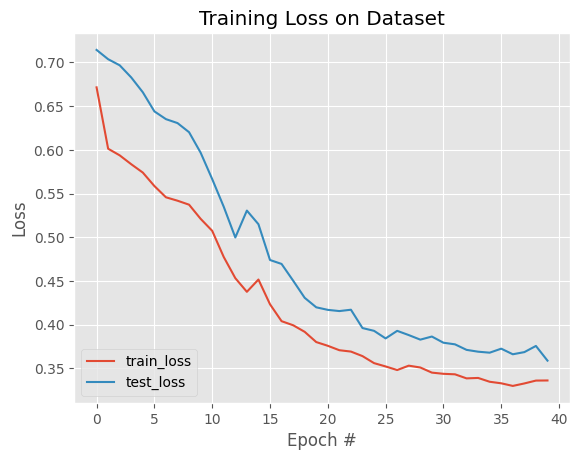

In [136]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"],label="train_loss")
plt.plot(H["test_loss"],label = "test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [138]:
torch.save(unet,MODEL_PATH)

Making Predictions

In [147]:
import numpy as np

In [156]:
def prepare_plot(origImage,predMask):
    figure, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
    
    ax[0].imshow(origImage)
    #ax[1].imshow(origMask)
    ax[1].imshow(predMask,cmap='gray')
    
    ax[0].set_title("Image")
    #ax[1].set_title("Original Mask")
    ax[1].set_title("Predicted Mask")
    
    figure.tight_layout()
    figure.show()

C:\Users\aayus\AppData\Local\Temp\ipykernel_42968\486299230.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


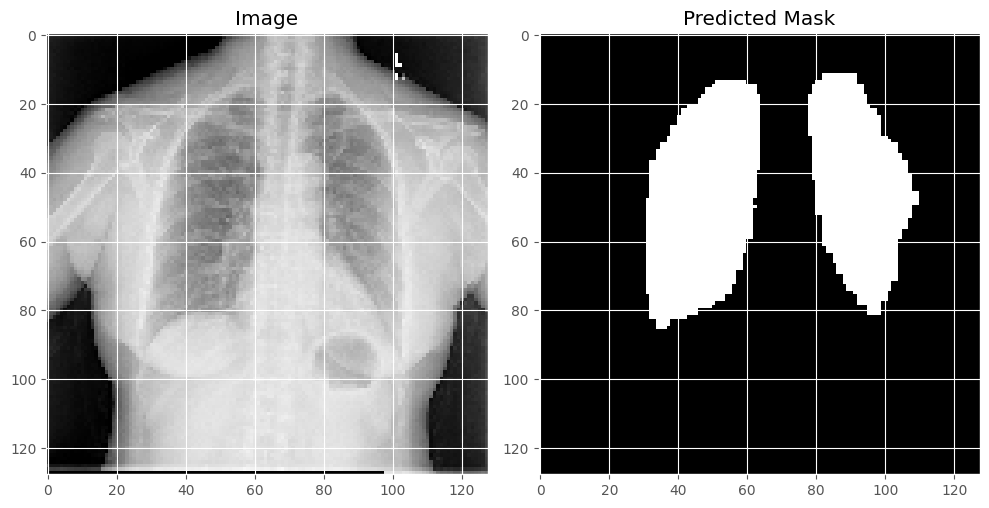

In [157]:
unet.eval()
    
with torch.inference_mode():
    image = cv2.imread("data/X_ray_image_and_mask_for_U_net_training/CXR_png/CHNCXR_0035_0.png")
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image.astype("float32")/255.0
    image = cv2.resize(image,(128,128))
        
    orig = image.copy()
        
       # filename = imagePath.split(os.path.sep)[-1]
        #groundTruthPath = os.path.join(masks_path,filename)
        
        #gtMask = cv2.imread(groundTruthPath,0)
        #gtMask = cv2.resize(gtMask,(INPUT_IMAGE_HEIGHT,INPUT_IMAGE_WIDTH))
        
    image = np.transpose(image,(2,0,1)) #to get it to [C,H,W] format
    image = np.expand_dims(image,0) #model inputs 4 dimensional tensor
    image = torch.tensor(image)
        
    predMask = unet(image).squeeze() #to remove extra dimension
    predMask = torch.sigmoid(predMask)
    predMask = predMask.numpy()
        
    predMask = (predMask>THRESHOLD) *255
    predMask = predMask.astype(np.uint8)
        
    prepare_plot(orig,predMask)